In [39]:
import os
import xarray as xr

folder_path =  "imd2/IMD"
imd_data = list()
for i in os.listdir(folder_path):
  path = os.path.join(folder_path, i)
  imd_data.append( path)
  

In [40]:
imd_data[0]

'imd2/IMD\\IMD_1986_regridded_pptn.nc'

In [41]:
import xarray as xr
import pandas as pd



# Function to extract data from a single file
def extract_data(file_path):
    ds = xr.open_dataset(file_path)
    extracted = ds.sel(
        LATITUDE=slice(19.125, 19.375,),
        LONGITUDE=slice(72.625,  72.875, )
    )
    return extracted.RAINFALL

# Extract data from all files
extracted_data_list = [extract_data(file) for file in imd_data]

# Combine the extracted data
combined_data = xr.concat(extracted_data_list, dim='TIME')

# Convert to DataFrame if needed
df = combined_data.to_dataframe().reset_index()

# Print the first few rows to verify
print(df.head())

# Save to CSV if needed
df.to_csv('combined_rainfall_data2.csv', index=False)

# Or save as a new NetCDF file
combined_data.to_netcdf('combined_rainfall_data.nc')

        TIME  LATITUDE  LONGITUDE  RAINFALL
0 1986-01-01    19.125     72.625       NaN
1 1986-01-01    19.125     72.875       0.0
2 1986-01-01    19.375     72.625       NaN
3 1986-01-01    19.375     72.875       0.0
4 1986-01-02    19.125     72.625       NaN


In [42]:
df["RAINFALL"]=df["RAINFALL"].fillna(0)

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

# Load the data
df = pd.read_csv('combined_rainfall_data2.csv')

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'],format="%Y-%m-%d")

# Create additional time-based features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['dayofweek'] = df['date'].dt.dayofweek

# Create lag features (previous day's rainfall)
df['rainfall_lag1'] = df.groupby(['lat', 'lon'])['rainfall'].shift(1)

# Drop rows with NaN values
df['rainfall_lag1'] = df['rainfall_lag1'].fillna(0)
df['rainfall'] = df['rainfall'].fillna(0)

# Prepare features and target
features = ['lat', 'lon', 'year', 'month', 'day', 'dayofweek', 'rainfall_lag1']
X = df[features]
y = df['rainfall']

# Split the data into training and testing sets
X_train= X[:49674]
y_train= y[:49674]
X_test = X[49674:]
y_test = y[49674:]



In [2]:
X_train.head() , y_train.head()

(      lat     lon  year  month  day  dayofweek  rainfall_lag1
 0  19.125  72.625  1986      1    1          2            0.0
 1  19.125  72.875  1986      1    1          2            0.0
 2  19.375  72.625  1986      1    1          2            0.0
 3  19.375  72.875  1986      1    1          2            0.0
 4  19.125  72.625  1986      1    2          3            0.0,
 0    0.0
 1    0.0
 2    0.0
 3    0.0
 4    0.0
 Name: rainfall, dtype: float64)

In [3]:
if np.any(np.isinf(X_train)):
    print("X_train contains infinite values.")
    
# Check for values too large for float32
if np.any(np.abs(X_train) > np.finfo(np.float32).max):
    print("X_train contains values too large for float32.")

if np.any(np.isinf(y_train)):
    print("y_train contains infinite values.")
    
# Check for values too large for float32
if np.any(np.abs(y_train) > np.finfo(np.float32).max):
    print("y_train contains values too large for float32.")


X_train contains values too large for float32.
y_train contains values too large for float32.


In [5]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
# Make predictions on the test set
model.fit(X_train_clean, y_train_clean)


RandomForestRegressor(random_state=42)

In [80]:
y_pred = model.predict(X_test_clean)

In [81]:
from sklearn.preprocessing import StandardScaler

# Apply scaling to both X_train and X_test
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_clean)
X_test_scaled = scaler.transform(X_test)

# Refit the model on the scaled data
model.fit(X_train_scaled, y_train_clean)

# Make predictions on the scaled test data
y_pred = model.predict(X_test_scaled)


Removed 0 rows with values too large for float32 from test data.


In [82]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test_clean, y_pred))
print(f"Root Mean Squared Error: {rmse}")


Root Mean Squared Error: 13.33481885553133


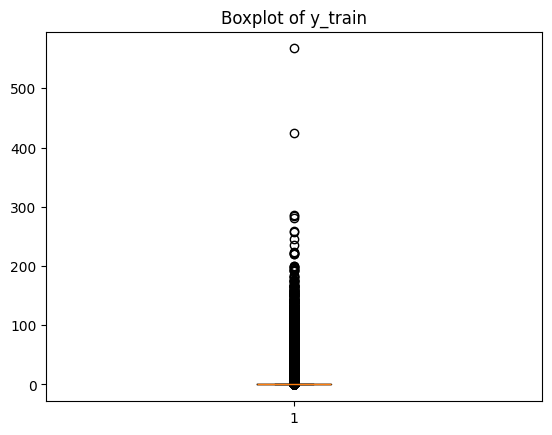

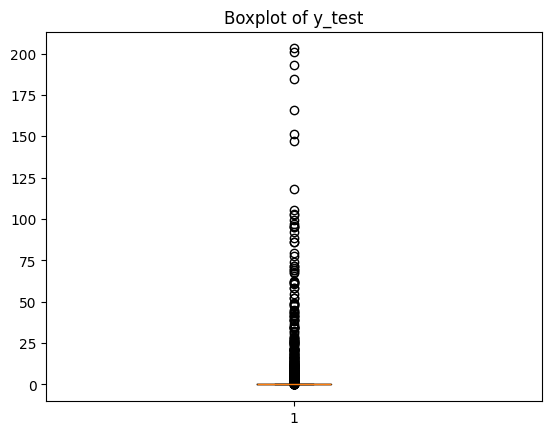

In [83]:
import matplotlib.pyplot as plt

plt.boxplot(y_train_clean)
plt.title("Boxplot of y_train")
plt.show()

plt.boxplot(y_test_clean)
plt.title("Boxplot of y_test")
plt.show()


In [84]:


# Function to predict rainfall for a given date and location
def predict_rainfall(date, lat, lon):
    # Create a DataFrame with the input data
    input_data = pd.DataFrame({
        'date': [pd.to_datetime(date)],
        'lat': [lat],
        'lon': [lon]
    })
    
    # Add time-based features
    input_data['year'] = input_data['date'].dt.year
    input_data['month'] = input_data['date'].dt.month
    input_data['day'] = input_data['date'].dt.day
    input_data['dayofweek'] = input_data['date'].dt.dayofweek
    
    # Add lag feature (you might want to update this based on your data)
    input_data['rainfall_lag1'] = df[(df['lat'] == lat) & (df['lon'] == lon)]['rainfall'].iloc[-1]
    
    # Make prediction
    prediction = model.predict(input_data[features])
    
    return prediction[0]

# Example usage


In [100]:
predict_rainfall('2024-11-30',19.125,72.625)

d:\FloodAihackthon\.venvv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


15.802008037790657

0.0


d:\FloodAihackthon\.venvv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
